<a href="https://colab.research.google.com/github/AyusheeMittal/legendary-guide/blob/master/Copy_of_Eva5_Assignment_6_Regularization_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Team Members**

Avneesh Nolkha

Ayushee Mittal

Smita Sasindran

Vishesh Sethi



## **Importing Libraries**

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## **Transforms**

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## **Dataset**

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## **Dataloader**

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## **Ghost Batch Normalization classes**

In [5]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)



## **Model**

In [6]:
dropout_value = 0.09
class Net(nn.Module):
    def __init__(self, gbn, gbn_split):
        super(Net, self).__init__()

        self.gbn = gbn
        self.gbn_split = gbn_split

        print("Is GBN run:", gbn)
        # Add BatchNorm or GhostBatchNorm
        def BNLayer(n_features):
            bn = nn.BatchNorm2d(n_features) if not self.gbn else GhostBatchNorm(n_features, self.gbn_split) 
            return bn


        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
            BNLayer(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            BNLayer(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10)
            nn.BatchNorm2d(10)
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(12),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(16),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(20),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [7]:
#Model Block 1
class Net(nn.Module):
    def __init__(self, gbn, gbn_split):
        super(Net, self).__init__()
        self.gbn = gbn
        self.gbn_split = gbn_split

        print("Is GBN run:", gbn)
        # Add BatchNorm or GhostBatchNorm
        def BNLayer(n_features):
            bn = nn.BatchNorm2d(n_features) if not self.gbn else GhostBatchNorm(n_features, self.gbn_split) 
            return bn

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10)
            BNLayer(10)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10)
            BNLayer(10)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16)
            BNLayer(16)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(12)
            BNLayer(12)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16)
            BNLayer(16)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(20)
            BNLayer(20)
        ) # output_size = 7

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16)
            BNLayer(16)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 7

        self.dropout = nn.Dropout2d(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## **Model Params**

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(False, 1).to(device)
summary(model, input_size=(1, 28, 28))

cuda
Is GBN run: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             900
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 16, 22, 22]           1,440
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 12, 11, 11]             192
             ReLU-12           [-1, 12, 11, 11]               0
      BatchNorm2d-13           [-1, 12, 11, 11]              24
           Conv2

## **Setting up parameters for 5 runs**

In [9]:
run_params = [
  {'model': 'L1_with_BN', 'l1': True, 'l2': False, 'gbn': False, 'gbn_split': 1, 'l_l1': 0.0000085},
  {'model': 'L2_with_BN', 'l1': False, 'l2': True, 'gbn': False, 'gbn_split': 1, 'l_l1': 0},
  {'model': 'L1_and_L2_with_BN', 'l1': True, 'l2': True, 'gbn': False, 'gbn_split': 1, 'l_l1': 0.00000000009},
  {'model': 'GBN', 'l1': False, 'l2': False, 'gbn': True, 'gbn_split': 2, 'l_l1': 0},
  {'model': 'L1_and_L2_with_GBN', 'l1': True, 'l2': True, 'gbn': True, 'gbn_split': 2, 'l_l1': 0.00000000000001}
]
    

In [10]:

train_losses = {}
train_acc = {}
test_losses = {}
test_acc = {}
for rp in run_params:
  train_losses[rp['model']] = []
  train_acc[rp['model']] = []
  test_losses[rp['model']] = []
  test_acc[rp['model']] = []



## **Training and Testing Loops**

In [11]:
from tqdm import tqdm

# train_losses = []
# train_acc = []
# test_losses = []
# test_acc = []

misclassified = []

#{'model': 'L1_with_BN', 'l1': True, 'l2': False, 'gbn': False, 'gbn_split': 1},
def train(model, device, train_loader, optimizer, epoch, params):
  name = params['model']

  model.train()
  pbar = tqdm(train_loader, position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    l1_reg = 0
    l2_reg = 0

    if params['l1']:
      for param in model.parameters():
        l1_reg += param.abs().sum()

    # if params['l2']:
    #   for param in model.parameters():
    #     l2_reg += param.norm(2)

    # Calculate loss
    loss = F.nll_loss(y_pred, target) + params['l_l1'] * l1_reg #+ lambda_l2 * l2_reg

    #train_losses.append(loss)
    train_losses[name].append(loss)


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #train_acc.append(100*correct/processed)
    train_acc[name].append(100*correct/processed)
  

def test(model, device, test_loader, params):
    name = params['model']

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    #test_losses.append(test_loss)
    test_losses[name].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    #test_acc.append(100. * correct / len(test_loader.dataset))
    test_acc[name].append(100. * correct / len(test_loader.dataset))

    

## **Running the models**

In [12]:
models = {}

optim_params = {
  'L1_with_BN':        {'lr':0.025, 'step_size': 12,'gamma': 0.2, 'weight_decay': 0},
  'L2_with_BN':        {'lr':0.025, 'step_size': 6, 'gamma': 0.1, 'weight_decay': 0.000095},
  'L1_and_L2_with_BN': {'lr':0.025, 'step_size': 6, 'gamma': 0.1, 'weight_decay': 0.000009},
  'GBN':               {'lr':0.025, 'step_size': 6, 'gamma': 0.1, 'weight_decay': 0},
  'L1_and_L2_with_GBN':{'lr':0.025, 'step_size': 6, 'gamma': 0.1, 'weight_decay': 0.0000001} 
}


for i, rp in enumerate(run_params):
    name = rp['model']
    opt = optim_params[name]
    print("\n\n ******** Running for: ", name, "====================================================")
    model =  Net(rp['gbn'], rp['gbn_split']).to(device)
    
    #optimizer = optim.SGD(model.parameters(), lr=0.0180, momentum=0.92)
    optimizer = optim.SGD(model.parameters(), lr=opt['lr'], momentum=0.9, weight_decay=opt['weight_decay'])
    scheduler = StepLR(optimizer, step_size=opt['step_size'], gamma=opt['gamma'])

    models[name] = model

    EPOCHS = 25
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch+1)
        train(model, device, train_loader, optimizer, epoch, rp)
        scheduler.step()
        test(model, device, test_loader, rp)


  0%|          | 0/469 [00:00<?, ?it/s]



 ******** Running for:  L1_with_BN ====================================================
Is GBN run: False
EPOCH: 1


Loss=0.047586590051651 Batch_id=468 Accuracy=93.45: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0720, Accuracy: 9780/10000 (97.80%)

EPOCH: 2


Loss=0.08392079919576645 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:15<00:00, 30.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9868/10000 (98.68%)

EPOCH: 3


Loss=0.012756433337926865 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9882/10000 (98.82%)

EPOCH: 4


Loss=0.09352466464042664 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 31.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.022475695237517357 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.017834655940532684 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9901/10000 (99.01%)

EPOCH: 7


Loss=0.1211862564086914 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.15520676970481873 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Loss=0.032127901911735535 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.033229488879442215 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.06850796937942505 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9912/10000 (99.12%)

EPOCH: 12


Loss=0.05499899014830589 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9904/10000 (99.04%)

EPOCH: 13


Loss=0.012434953823685646 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.019339516758918762 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:14<00:00, 32.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.020838607102632523 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.01096355076879263 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.04817938059568405 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.01735781505703926 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9924/10000 (99.24%)

EPOCH: 19


Loss=0.009636909700930119 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9928/10000 (99.28%)

EPOCH: 20


Loss=0.01106911338865757 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9928/10000 (99.28%)

EPOCH: 21


Loss=0.011740226298570633 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9929/10000 (99.29%)

EPOCH: 22


Loss=0.03936079144477844 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.0230497308075428 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9932/10000 (99.32%)

EPOCH: 24


Loss=0.010507270693778992 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9924/10000 (99.24%)

EPOCH: 25


Loss=0.015050999820232391 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:14<00:00, 31.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9929/10000 (99.29%)



 ******** Running for:  L2_with_BN ====================================================
Is GBN run: False
EPOCH: 1


Loss=0.04160846024751663 Batch_id=468 Accuracy=93.60: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9833/10000 (98.33%)

EPOCH: 2


Loss=0.028750034049153328 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.1284441500902176 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9844/10000 (98.44%)

EPOCH: 4


Loss=0.025593185797333717 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9872/10000 (98.72%)

EPOCH: 5


Loss=0.007269354537129402 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.05260096490383148 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 33.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.0015585358487442136 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

EPOCH: 8


Loss=0.013495209626853466 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.001932071871124208 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.015611216425895691 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.06115948036313057 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.007530607748776674 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 33.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.006074739620089531 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


Loss=0.020930113270878792 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.013531186617910862 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.44%)

EPOCH: 16


Loss=0.011616977863013744 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9943/10000 (99.43%)

EPOCH: 17


Loss=0.0018994769779965281 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9943/10000 (99.43%)

EPOCH: 18


Loss=0.03515801206231117 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


Loss=0.08505924791097641 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:13<00:00, 34.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9944/10000 (99.44%)

EPOCH: 20


Loss=0.00266945268958807 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:13<00:00, 34.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9945/10000 (99.45%)

EPOCH: 21


Loss=0.003296604612842202 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:13<00:00, 34.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.009916013106703758 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9944/10000 (99.44%)

EPOCH: 23


Loss=0.0010738997953012586 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 24


Loss=0.005276810377836227 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 34.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9946/10000 (99.46%)

EPOCH: 25


Loss=0.07128507643938065 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 35.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9944/10000 (99.44%)



 ******** Running for:  L1_and_L2_with_BN ====================================================
Is GBN run: False
EPOCH: 1


Loss=0.1659460812807083 Batch_id=468 Accuracy=93.06: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0776, Accuracy: 9766/10000 (97.66%)

EPOCH: 2


Loss=0.033706530928611755 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1177, Accuracy: 9638/10000 (96.38%)

EPOCH: 3


Loss=0.0776861310005188 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9850/10000 (98.50%)

EPOCH: 4


Loss=0.009049490094184875 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9851/10000 (98.51%)

EPOCH: 5


Loss=0.04798010736703873 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.016591744497418404 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.01582890748977661 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.02499879151582718 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.047403376549482346 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.03722913935780525 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.026354990899562836 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9947/10000 (99.47%)

EPOCH: 12


Loss=0.00535610830411315 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.0050308676436543465 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.015661122277379036 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.0398571640253067 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.07965303957462311 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.004904213361442089 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.0027339356020092964 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.018705397844314575 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH: 20


Loss=0.01053981576114893 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.005441613495349884 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.027603236958384514 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 33.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.020395582541823387 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


Loss=0.001686316798441112 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.37%)

EPOCH: 25


Loss=0.010109425522387028 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9938/10000 (99.38%)



 ******** Running for:  GBN ====================================================
Is GBN run: True
EPOCH: 1


Loss=0.04080190137028694 Batch_id=468 Accuracy=93.23: 100%|██████████| 469/469 [00:13<00:00, 34.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9801/10000 (98.01%)

EPOCH: 2


Loss=0.02769782952964306 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:13<00:00, 35.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9869/10000 (98.69%)

EPOCH: 3


Loss=0.08926365524530411 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.015244563110172749 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9871/10000 (98.71%)

EPOCH: 5


Loss=0.054897189140319824 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 34.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.036353908479213715 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.012620653957128525 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.0784020945429802 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.016356175765395164 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 34.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.006443571299314499 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.005486130248755217 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.026189029216766357 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 35.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.008274701423943043 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.08821997046470642 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.013462062925100327 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 34.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.03298424929380417 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.009989330545067787 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.004246934317052364 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.08720750361680984 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.010664432309567928 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9933/10000 (99.33%)

EPOCH: 21


Loss=0.009560640901327133 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.008923898451030254 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:13<00:00, 35.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.01262510847300291 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:12<00:00, 36.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9932/10000 (99.32%)

EPOCH: 24


Loss=0.06746739894151688 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:12<00:00, 36.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)

EPOCH: 25


Loss=0.011365833692252636 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:12<00:00, 36.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9931/10000 (99.31%)



 ******** Running for:  L1_and_L2_with_GBN ====================================================
Is GBN run: True
EPOCH: 1


Loss=0.031726133078336716 Batch_id=468 Accuracy=93.13: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9799/10000 (97.99%)

EPOCH: 2


Loss=0.07376376539468765 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.03546133637428284 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.05998022481799126 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.058358240872621536 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.06924328953027725 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9901/10000 (99.01%)

EPOCH: 7


Loss=0.0505179725587368 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 30.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.08004868030548096 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.12025503069162369 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.0027310699224472046 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.004232124425470829 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.01447733398526907 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.051063522696495056 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.027480928227305412 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.003992496989667416 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.013884241692721844 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.017451053485274315 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 31.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.025466205552220345 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.10791542381048203 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.06060445308685303 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 31.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9931/10000 (99.31%)

EPOCH: 21


Loss=0.0073476326651871204 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 31.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.03385685011744499 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 23


Loss=0.02324589155614376 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.037820447236299515 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9934/10000 (99.34%)

EPOCH: 25


Loss=0.059954870492219925 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]



Test set: Average loss: 0.0197, Accuracy: 9931/10000 (99.31%)



## **Plotting functions**

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from google.colab import files

def plot_with_legends(run_params, data, title):
    figure = plt.figure()
    #figure.suptitle(title, fontsize=16)
    plt.figure(figsize=(15,8))
    
    for i, pld in enumerate(run_params):
        name = pld['model']
        plt.plot(data[name], label=name)

    plt.legend()
    plt.title(title)
    fname = name + "_" + title  
    plt.savefig(fname + ".png")
    files.download(fname + ".png") 
    plt.show()  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

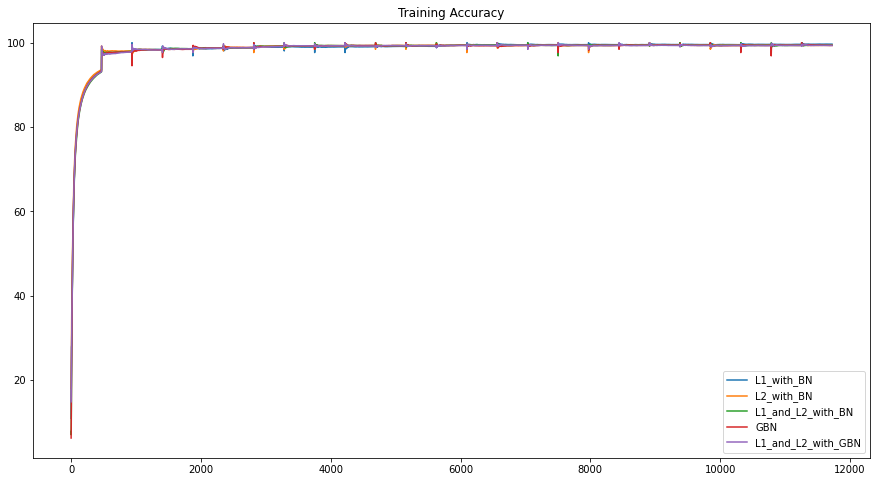

In [14]:
plot_with_legends(run_params, train_acc, 'Training Accuracy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

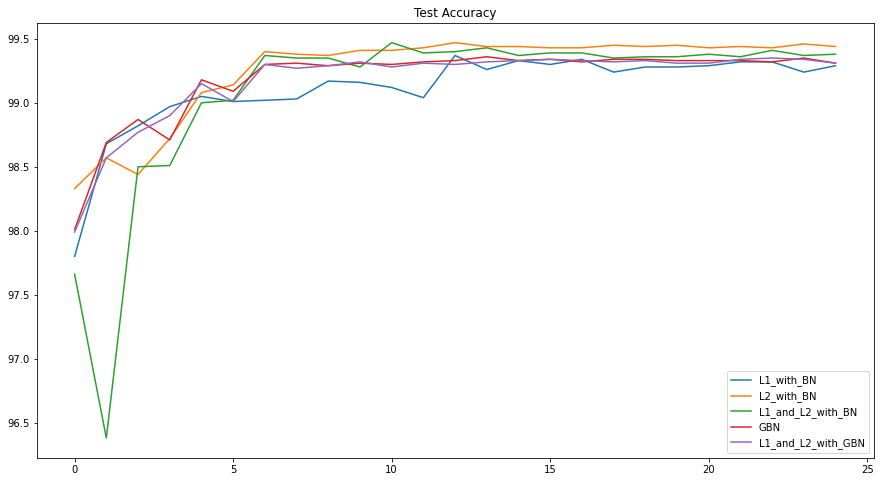

In [15]:

plot_with_legends(run_params, test_acc, 'Test Accuracy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

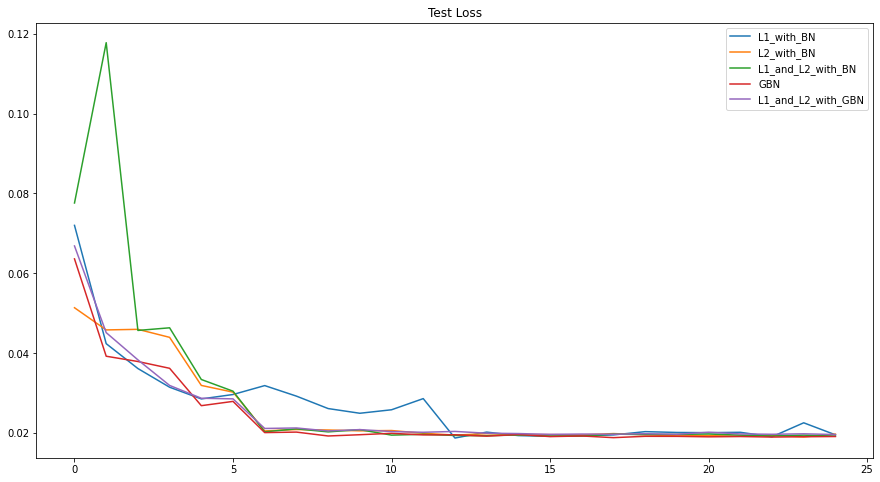

In [16]:
plot_with_legends(run_params, test_losses, 'Test Loss')

In [17]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# def plot_combined_graphs(run_params, data, title):
#     #figure = plt.figure()
#     fig, axs = plt.subplots(1, 5,figsize=(25,5))
#     fig.suptitle(title, fontsize=16)
#     for i, pld in enumerate(run_params):
#         name = pld['model']
#         axs[i].plot(data[name])
#         axs[i].set_title(name)

# #plot_combined_graphs(run_params, train_losses, 'Train Losses')
# plot_combined_graphs(run_params, train_acc, 'Train Acc')
# #plot_combined_graphs(run_params, test_losses, 'Test Losses')
# plot_combined_graphs(run_params, test_acc, 'Test Acc')

## **Misclassified Images with GBN**

In [18]:
gbn_model = models['GBN']


incorrect_indexes = {} # {23: {'actual': 1, 'predicted': 4}}
gbn_model.eval()
count = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = gbn_model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        for sampleno in range(data.shape[0]):
                if(target[sampleno]!=pred[sampleno]):
                    count += 1
                    #print("Index=", sampleno, ", Actual=", target[sampleno].cpu().numpy(), ", Predicted: ", pred[sampleno].cpu().numpy()[0])
                    incorrect_indexes[sampleno] = {'actual': target[sampleno].cpu().numpy(), 
                                                   'predicted': pred[sampleno].cpu().numpy()[0], 
                                                   'data': data[sampleno].cpu().numpy()}

#print(incorrect_indexes) 
print(len(incorrect_indexes))
print(count)

54
69


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

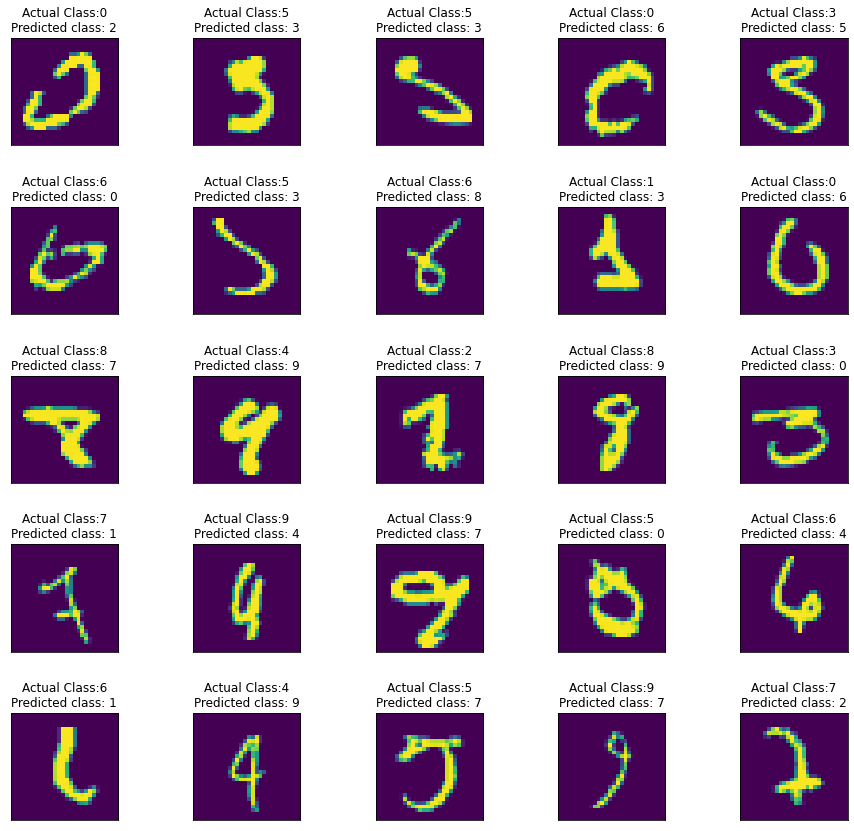

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

#{23: {'actual': 1, 'predicted': 4}}
x = 0
y = 0
fig, axs = plt.subplots(5, 5, figsize = (15, 15))
plt.setp(axs, xticks=[], yticks=[])
fig.subplots_adjust(wspace=0.7)
images = list(incorrect_indexes.items())[:25]
for index, results in images:
  #print(index)
  img = results['data'] 
  img = np.squeeze(img)
  actual_class = results['actual'] 
  predicted_class =  results['predicted'] 

  plt.savefig("misclassified.png")
  files.download("misclassified.png")  
  axs[x, y].imshow(img)
  axs[x, y].set_title('Actual Class:' + str(actual_class) + "\nPredicted class: " + str(predicted_class))
  
  if y == 4:
    x += 1
    y = 0
  else:
    y += 1

plt.savefig("misclassified.png")
files.download("misclassified.png")     